In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os, pathlib, sys
from IPython.display import clear_output

In [2]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [3]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [4]:
import matplotlib.ticker as mtick
import matplotlib.dates as md
import matplotlib.gridspec as gridspec

tick    = mtick.StrMethodFormatter('\${x:,.0f}')
tick2   = mtick.StrMethodFormatter('\${x:,.2f}')
normal  = mtick.StrMethodFormatter('{x:,.0f}')
normal2 = mtick.StrMethodFormatter('{x:,.2f}')

colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}

In [5]:
colors       = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 8, 'color': colors['grey'], 'labelcolor': colors['grey'], "labelsize":8}
config_title = {'size': 8, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}

def rescale_plot(W=5, l=6, w=3):
    plt.rcParams.update({
            'figure.figsize': (W, W/(l/w)),     # 6:3 aspect ratio
            'font.size' : 10,                   # Set font size to 11pt
            'axes.labelsize': 10,               # -> axis labels
            'legend.fontsize': 10,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })

In [16]:
data_path     = pathlib.Path(os.path.abspath(os.path.join('..')), "data")
reward_path   = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Rewards")
feature_path  = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Features")

In [17]:
def add_fwd_cols(all_fwd_cols, _LOB_features):
    for col in all_fwd_cols:
        fwd_w = int(col.split('_')[-1])
        _LOB_features[col] = _LOB_features['mid_price'].diff(int(fwd_w/10)).shift(-int(fwd_w/10))

# Load Data & construct features

In [18]:
from AOE.utils import get_LOB_data, get_LOB_features, verbose_print #get_features
from AOE.plots import rescale_plot

In [19]:
asset_name    = "COST"
trade_date    = '2022-10-03'
tick_size     = 0.01
features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'

LOB_features  = pd.read_pickle(f'../data/Features/{features_fn}')

# Statistics

In [20]:
if False:
    signal_names  = ["imbalance_1", "MR", "TF"]
    verbose       = True
    i_file        = 0
    list_files    = os.listdir(f'../data/Features')
    for filename in list_files:
        f = os.path.join(f'../data/Features/' ,filename)
        if 'features' in f:
            if os.path.isfile(f):
                i_file     += 1
                trade_date = f.split('_')[-1].split('.')[0]
                clear_output(wait=True)
                print('trade_date:', trade_date)
                print(f'{ round(100*i_file/len(list_files))} %')
                # if os.path.isfile(os.path.join(reward_path, f'{trade_date}_rewards.pkl')):
                #     print('File already exists')
                # else:
                LOB_features = pd.read_pickle(f).set_index('timestamp')
                LOB_features['TF'] = LOB_features['macd_12_26_9']
                LOB_features['MR'] = LOB_features['macd_12_26_9']  

                LOB_features['imbalance_1'] = LOB_features['imbalance_1'].rolling(10).mean()
                LOB_features['TF'] = LOB_features['TF'].rolling(10).mean()
                LOB_features['MR'] = LOB_features['MR'].rolling(10).mean()

                res = get_rewards(LOB_features, signal_names, verbose)
                export_reward_results(signal_names, LOB_features, trade_date, res, reward_path)

# Plot data

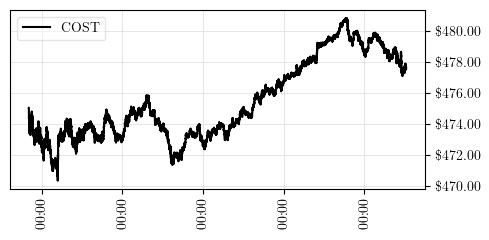

In [21]:
import matplotlib.dates as md
import matplotlib.gridspec as gridspec

rescale_plot(W=5, l=6, w=3)
fig, ax = plt.subplots(1, 1)

xfmt = md.DateFormatter('%H:%M')

ax.plot(LOB_features.index, LOB_features['mid_price'], color='k')
ax.yaxis.set_major_formatter(tick2)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_label_position("left")
ax.legend([asset_name], fancybox=True, framealpha=0.5,loc="upper left")
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig(f'plots/NUM1_{asset_name}.pdf', bbox_inches='tight')
plt.show()
# plt.savefig('plots/MSFT_LOB_data.pdf')

In [22]:
fwd_cols = []
fwd_col_l = (1, 5, 10, 20, 50, 40, 60, 100, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000)
for w in fwd_col_l:
    fwd_cols += [f'fwd_price_move_{w}']

add_fwd_cols(fwd_cols, LOB_features)

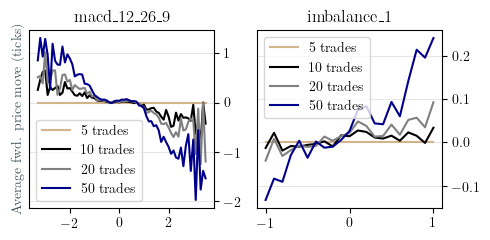

In [23]:
# plt.rcParams['figure.figsize'] = (15., 13. / 16 * 12)
rescale_plot(W=5, l=6, w=3)

fig = plt.figure()
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

predictive_feature_1 = 'macd_12_26_9'
counts = (LOB_features[[predictive_feature_1] + fwd_cols].round(1).groupby(predictive_feature_1).count().iloc[1:-1])
avgs   = (LOB_features[[predictive_feature_1] + fwd_cols].round(1).groupby(predictive_feature_1).mean().iloc[1:-1]/tick_size)

avgs[counts<100]=np.nan
ax1.plot(avgs.iloc[:,1], color='tan')
ax1.plot(avgs.iloc[:,2], color='k')
ax1.plot(avgs.iloc[:,3], color='grey')
ax1.plot(avgs.iloc[:,4], color='darkblue')

predictive_feature_2 = 'imbalance_1'
counts = (LOB_features[[predictive_feature_2] + fwd_cols].round(1).groupby(predictive_feature_2).count())
avgs = (LOB_features[[predictive_feature_2] + fwd_cols].round(1).groupby(predictive_feature_2).mean()/tick_size)
avgs[counts<100]=np.nan
ax2.plot(avgs.iloc[:,1], color='tan')
ax2.plot(avgs.iloc[:,2], color='k')
ax2.plot(avgs.iloc[:,3], color='grey')
ax2.plot(avgs.iloc[:,4], color='darkblue')

# ax1.set_xlim(-0.5, 0.5)
for ax in (ax1,ax2):
    ax.yaxis.tick_right()
    #ax.tick_params(axis='both', **config_ticks)
    ax.yaxis.set_label_position("left")
    ax.yaxis.label.set_color(colors['grey'])
    ax.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

ax1.legend([f'{fwd_col_l[s]} trades' for s in (1, 2, 3, 4)])
ax2.legend([f'{fwd_col_l[s]} trades' for s in (1, 2, 3, 4)])

ax1.set_ylabel('Average fwd. price move (ticks)')
ax1.set_title(predictive_feature_1)
ax2.set_title(predictive_feature_2)

plt.tight_layout()
# plt.savefig('MSFT_predictive_features.pdf')

### Same as above but for the whole month

In [24]:
from AOE.utils import get_LOB_data, get_LOB_features, get_meta_order_df, verbose_print

In [25]:
def ema(series, periods, fillna=False):
    if fillna:
        return series.ewm(span=periods, min_periods=0).mean()
    return series.ewm(span=periods, min_periods=periods).mean()

def rsi(close, n=14, rtrfreq=1, fillna=False): # n in number of trades
    diff = close.diff(rtrfreq)
    which_dn = diff < 0

    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]

    emaup = ema(up, n, fillna)
    emadn = ema(dn, n, fillna)

    rsi = 100 * emaup / (emaup + emadn)
    if fillna:
        rsi = rsi.replace([np.inf, -np.inf], np.nan).fillna(50)
    return pd.Series(rsi, name='rsi')

Reading: 2022-12-19


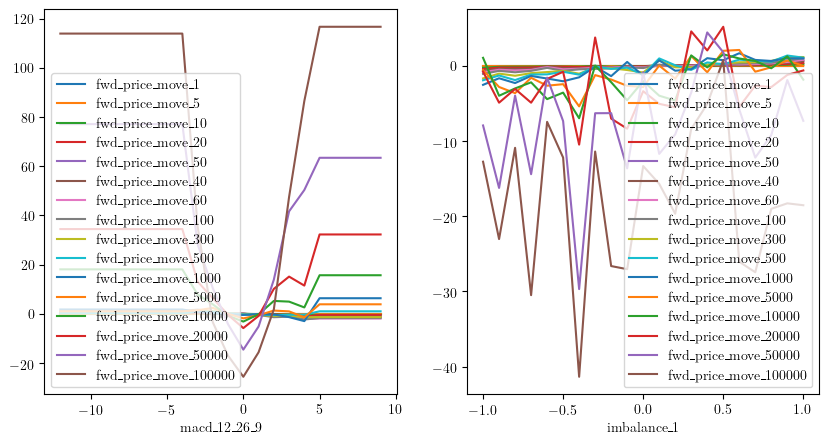

Reading: 2022-11-17


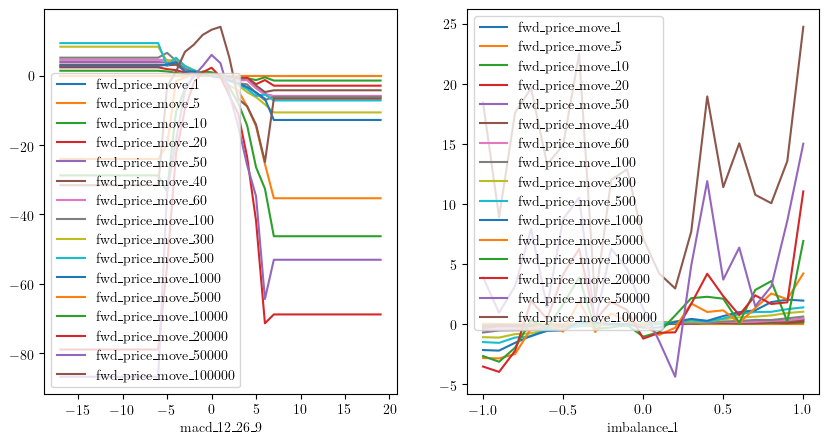

Reading: 2022-11-29


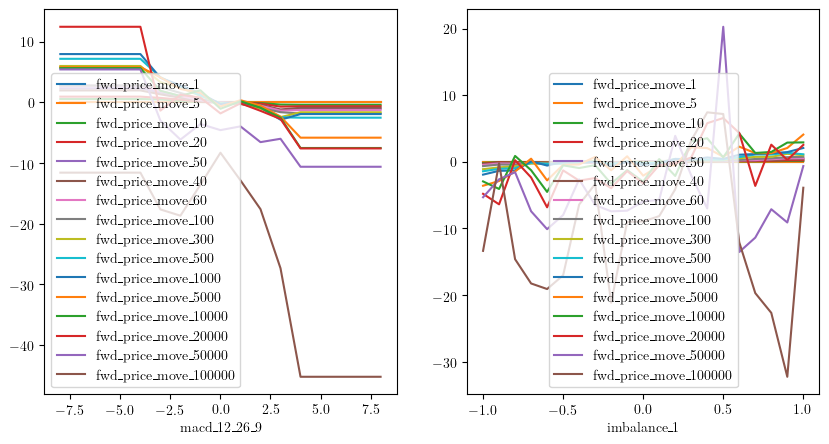

Reading: 2022-11-02


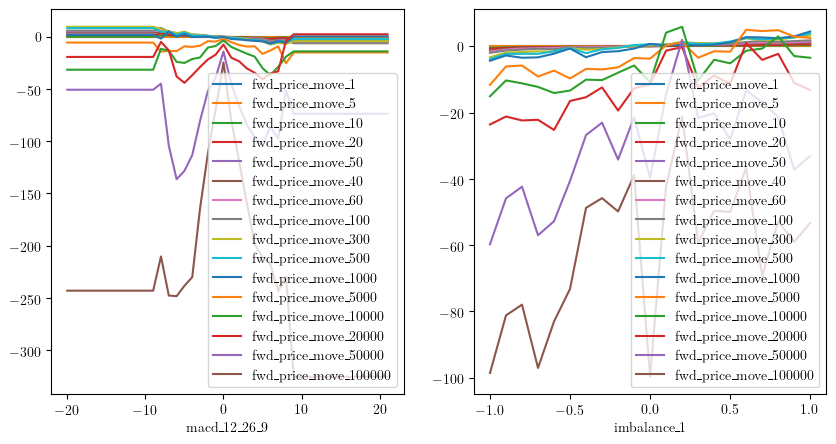

Reading: 2022-12-23


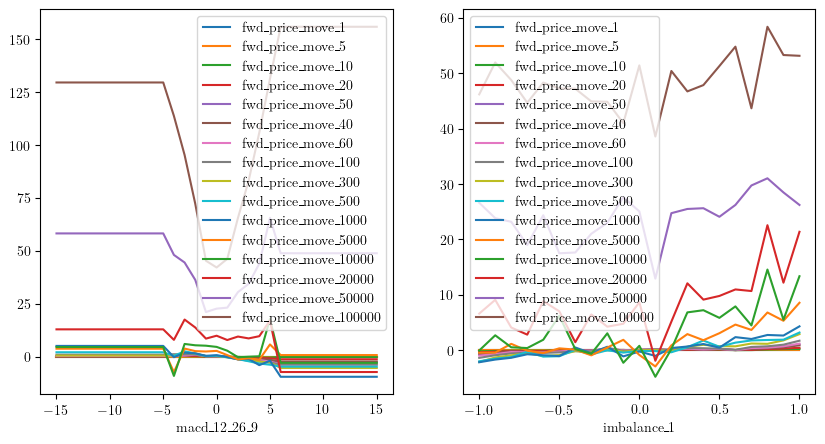

Reading: 2022-10-12


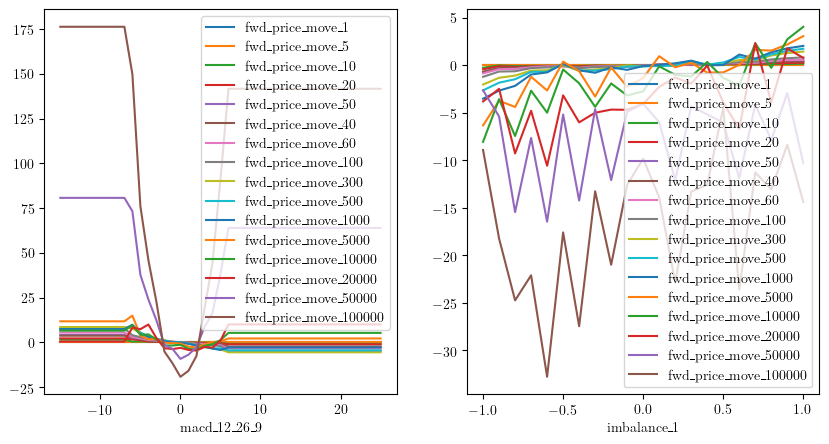

Reading: 2022-11-11


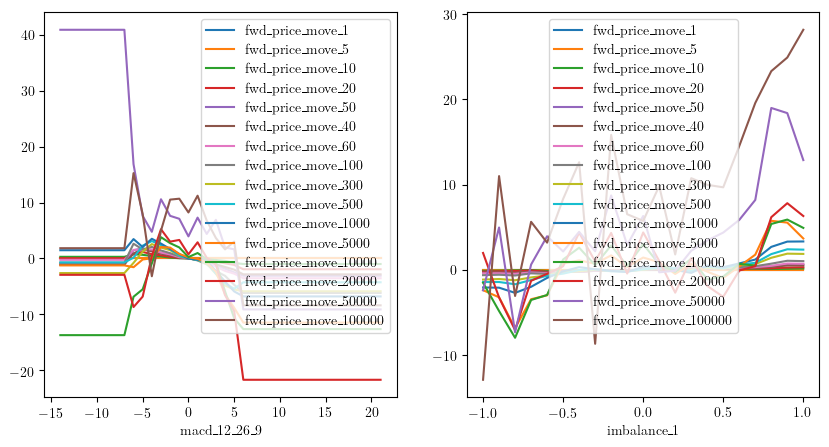

Reading: 2022-10-28


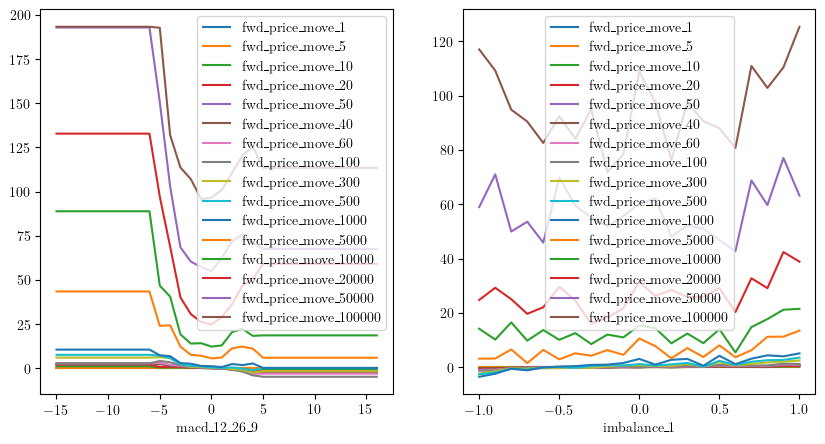

Reading: 2022-12-05
error


FileNotFoundError: [Errno 2] No such file or directory: '/Users/faycaldrissi/Library/CloudStorage/OneDrive-Personal/Documents/PhD/Main/AOE/AOE3/nb_trading/..//Users/faycaldrissi/Library/CloudStorage/OneDrive-Personal/Documents/PhD/Main/AOE/AOE3/data/COST/COST_2022-12-05_34200000_57600000_orderbook_5_part1.csv'

In [26]:
dic_results    = {}

feature_1_name = 'macd_12_26_9'
feature_2_name = 'imbalance_1'

filenames      = os.listdir('../data/Features')
trade_dates    = [fn.split('_')[1] for fn in filenames]

for trade_date in trade_dates:
    print('Reading:',trade_date)
    features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
    try:
        LOB_features = pd.read_pickle(f'../data/Features/{features_fn}')
    except Exception as e:
        print('error')
        LOB_data, LOB_messages     = get_LOB_data(f'{os.getcwd()}/../{data_path}', asset_name, trade_date)
        LOB_features  = get_LOB_features(LOB_data,
                                         trade_date = trade_date,
                                         LOB_msg    = LOB_messages)
        LOB_features.to_pickle(f'../data/Features/LOB_features_{trade_date}.pkl')
    
    LOB_features[feature_1_name] = LOB_features[feature_1_name].round(0)
    LOB_features[feature_2_name] = LOB_features[feature_2_name].round(1)
    
    add_fwd_cols(fwd_cols, LOB_features)
    
    LOB_features_predictive = LOB_features[[feature_1_name, feature_2_name] + fwd_cols].dropna()
    
    predictive_feature = feature_1_name
    counts1 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
    avgs1   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean()/tick_size)
    avgs1[counts1<100]=np.nan
    avgs1 = avgs1.sort_index().fillna(method='ffill').fillna(method='bfill')
    
    predictive_feature = feature_2_name
    counts2 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
    avgs2   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean()/tick_size)
    avgs2[counts2<100]=np.nan
    avgs2 = avgs2.sort_index().fillna(method='ffill').fillna(method='bfill')
    
    dic_results[trade_date] = (counts1, avgs1, counts2, avgs2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    avgs1.plot(ax=ax1) 
    avgs2.plot(ax=ax2)
    plt.show()

In [ ]:
#pd.concat((pd.concat((dic_results[s][1][colname] 
#            for s in dic_results.keys()), axis=1).dropna().mean(axis=1).rolling(2).mean() for colname in fwd_cols), axis=1)

In [27]:
avgs1 = pd.concat((pd.concat((dic_results[s][1][colname] 
            for s in dic_results.keys()), axis=1).dropna().mean(axis=1).rolling(2).mean() for colname in fwd_cols), axis=1)
avgs2 = pd.concat((pd.concat((dic_results[s][3][colname]
            for s in dic_results.keys()), axis=1).dropna().mean(axis=1).rolling(2).mean() for colname in fwd_cols), axis=1)

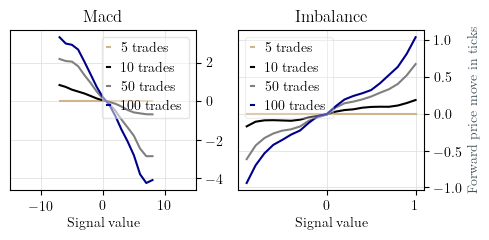

In [28]:
rescale_plot(W=5, l=6, w=3)

fig = plt.figure()
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#trend
ax1.plot(avgs1.iloc[:,1], color='tan')
ax1.plot(avgs1.iloc[:,2], color='k')
ax1.plot(avgs1.iloc[:,4], color='grey')
ax1.plot(avgs1.iloc[:,7], color='darkblue')

ax2.plot(avgs2.iloc[:,1], color='tan')
ax2.plot(avgs2.iloc[:,2], color='k')
ax2.plot(avgs2.iloc[:,4], color='grey')
ax2.plot(avgs2.iloc[:,7], color='darkblue')

for ax in (ax1,ax2):
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set_color(colors['grey'])
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
ax2.legend([f'{fwd_col_l[s]} trades' for s in (1, 2, 4, 7)], 
           loc='upper left', fancybox=True, framealpha=0.3, handlelength=0.2)
ax1.legend([f'{fwd_col_l[s]} trades' for s in (1, 2, 4, 7)], 
           loc='upper right', fancybox=True, framealpha=0.5, handlelength=0.2)

ax1.set_xlim(-15, 15)
ax2.set_ylabel('Forward price move in ticks')
ax1.set_xlabel('Signal value')
ax2.set_xlabel('Signal value')

ax1.set_title('Macd')
ax2.set_title('Imbalance')

plt.tight_layout()
plt.savefig(f'plots/NUM2_{asset_name}.pdf', bbox_inches='tight')

In [ ]:
avgs1.fillna(method='bfill').to_pickle(f'models/rsi_model_{asset_name}.pkl')
avgs2.fillna(method='bfill').to_pickle(f'models/imb_model_{asset_name}.pkl')

In [ ]:
# # rolling averaged predicted movement
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# predictive_feature = 'imbalance_1_rounded'
# rolling_predictive_power = LOB_features_predictive[[predictive_feature, 'Avg_price_move_60']]
# reindex_features = LOB_features.loc[rolling_predictive_power.index]
# # rolling_predictive_power.index = .timestamp
# rolling_predictive_power = pd.concat( (rolling_predictive_power.iloc[-i:-i+3000].groupby(predictive_feature).mean().T/tick_size for i in range(3001,len(rolling_predictive_power),1000)), axis=0)
# rolling_predictive_power.index = (reindex_features.timestamp.values[-i+3000] for i in range(3001,len(LOB_features_predictive),1000))
# rolling_predictive_power[::-1].loc[:,np.sort(LOB_features_predictive[predictive_feature].unique())].loc[:, -1:-0.75].fillna(method='ffill').mean(axis=1).plot(color='k', ax=ax1)

# predictive_feature = 'price_trend_2_rounded'
# rolling_predictive_power = LOB_features_predictive[[predictive_feature, 'Avg_price_move_60']]
# reindex_features = LOB_features.loc[rolling_predictive_power.index]
# # rolling_predictive_power.index = .timestamp
# rolling_predictive_power = pd.concat( (rolling_predictive_power.iloc[-i:-i+3000].groupby(predictive_feature).mean().T/tick_size for i in range(3001,len(rolling_predictive_power),1000)), axis=0)
# rolling_predictive_power.index = (reindex_features.timestamp.values[-i+3000] for i in range(3001,len(LOB_features_predictive),1000))
# rolling_predictive_power[::-1].loc[:,np.sort(LOB_features_predictive[predictive_feature].unique())].loc[:, -0.004:-0.002].fillna(method='ffill').mean(axis=1).plot(color='k', ax=ax2)

# Evidence of non stationarity

In [ ]:
trade_date    = '2022-10-02'
tick_size     = 0.01

LOB_features = pd.read_pickle(f'../data/Features/{features_fn}')
add_fwd_cols(fwd_cols, LOB_features)

#except Exception as e:
#    LOB_data, LOB_messages     = get_LOB_data(f'../data/Market', asset_name, trade_date)
#    LOB_features  = get_LOB_features(LOB_data,
#                                 LOB_msg    = LOB_messages,
#                                 trade_date = trade_date)
    
#LOB_data      = get_LOB_data(f'{os.getcwd()}/{data_path}' , asset_name, trade_date)
#LOB_features  = get_features(LOB_data,
#                             trade_date = trade_date,
#                             trend      = ({'w' : 50},),
#                             vol        = (),
#                             depth      = {'w' : 500})

#LOB_features_predictive = LOB_features
#[['imbalance_1',
#                                        "trend_0_rounded",'fwd_price_move_5', 'fwd_price_move_10', 
#                                        'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_100']].dropna()

In [ ]:
LOB_features_predictive.columns

In [ ]:
fwd_cols             = ['fwd_price_move_5', 'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_100']
predictive_feature_1 = 'imbalance_1'
predictive_feature_2 = 'macd_120_260_90'
fwd_window           = 'fwd_price_move_50'

df_predictive_power  = LOB_features[[fwd_window, predictive_feature_1, predictive_feature_2]]
df_predictive_power[fwd_window] = df_predictive_power[fwd_window]/tick_size

In [ ]:
avgs1_[8].plot()

In [ ]:
avgs1_ = avgs1.reindex(avgs1.index.union(df_predictive_power[predictive_feature_1].unique())).sort_index().fillna(method='ffill').fillna(method='bfill')
avgs2_ = avgs2.reindex(avgs2.index.union(df_predictive_power[predictive_feature_2].unique())).sort_index().fillna(method='ffill').fillna(method='bfill')

avgs1_     = avgs1_[3]
avgs2_     = avgs2_[3]

In [ ]:
rolling_w            = 5000
lastwindow           = '4h'

# df_predictive_power[predictive_feature_1] = df_predictive_power[predictive_feature_1].round(4)
# df_predictive_power[predictive_feature_1] = df_predictive_power[predictive_feature_1].round(2)

df_predictive_power['predictive_move_feature_1'] = avgs1_.loc[df_predictive_power[predictive_feature_1]].values
df_predictive_power['predictive_move_feature_2'] = avgs2_.loc[df_predictive_power[predictive_feature_2]].values

print(LOB_features.timestamp.diff(rolling_w).mean()/np.timedelta64(1,"s"))

df_predictive_power['MAE_feature_1'] = ((df_predictive_power[fwd_window] - \
                                        df_predictive_power["predictive_move_feature_1"]).abs()
                                       ).rolling(rolling_w, min_periods=rolling_w).mean()

df_predictive_power['MAE_feature_2'] = ((df_predictive_power[fwd_window] - \
                                        df_predictive_power["predictive_move_feature_2"]).abs()
                                       ).rolling(rolling_w, min_periods=rolling_w).mean()

# df_predictive_power = df_predictive_power.iloc[0:len(df_predictive_power):rolling_w]

best_dynamics_feature = df_predictive_power[['MAE_feature_1', 'MAE_feature_2']].idxmin(axis=1).dropna()

best_dynamics_feature[ best_dynamics_feature== 'MAE_feature_1'] = 1
best_dynamics_feature[ best_dynamics_feature== 'MAE_feature_2'] = 2

print(len(np.diff(best_dynamics_feature.diff(1)[best_dynamics_feature.diff(1)!=0])))
print(np.mean(np.diff(best_dynamics_feature.diff(1)[best_dynamics_feature.diff(1)!=0].index.values)))

fig, (ax1, ax2) = plt.subplots(1, 2)

pd.concat((LOB_features.loc[best_dynamics_feature.index].timestamp, 
           best_dynamics_feature), axis=1
         ).set_index('timestamp').first(lastwindow).plot(ax=ax1)

pd.concat((LOB_features.loc[best_dynamics_feature.index].timestamp, best_dynamics_feature
          ), axis=1).set_index('timestamp').last(lastwindow).plot(ax=ax2)
plt.show()

In [ ]:
# w = 1000000

df_to_plot = pd.concat((LOB_features.loc[df_predictive_power.index].timestamp, 
                        df_predictive_power), axis=1)
# plt.plot(LOB_features.loc[df_predictive_power.iloc[:w].index].timestamp.values,
#           df_predictive_power[['MAE_feature_1']].iloc[:w].values, color='k')
# plt.plot(LOB_features.loc[df_predictive_power.iloc[:w].index].timestamp.values,
#           df_predictive_power[['MAE_feature_2']].iloc[:w].values, color='blue')
# df_to_plot.set_index('timestamp').last('8h')[['MAE_feature_1', 'MAE_feature_2']].plot()
df_to_plot.reset_index().iloc[-200000:][['MAE_feature_1', 'MAE_feature_2']].plot()

In [ ]:
LOB_features.loc[df_predictive_power.iloc[-w:].index].timestamp.values

In [ ]:
cols = rolling_predictive_power.Avg_price_move_60.unique()